# Introduction

This notebook shows different techniques to detect and remove outliers in data using uni-variate and multi-variate techniques.

This is often helpful in ...
- Data Science before generating a plot and/or descriptive statistics
- Machine Learning before training a model

# Percentile-Based Outlier Detection

Core idea:
- choose lower and upper percentiles (e.g. 5th and 95th)
- any value below or above these thresholds is considered an outlier
- this approach makes no assumptions about the data distribution

In [1]:
import numpy as np
import pandas as pd

# Sample data with clear outliers
data = pd.Series([10, 7, -3, 19, 12, 11, 13, 12, 11, 10, 14, 13, 500, -100])

# Define percentiles
lower_percentile = 5
upper_percentile = 95

# Compute percentile thresholds
lower_bound = np.percentile(data, lower_percentile)
upper_bound = np.percentile(data, upper_percentile)

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

# Detect outliers
outliers = data[(data < lower_bound) | (data > upper_bound)]
inliers = data[(data >= lower_bound) & (data <= upper_bound)]

print("\nOutliers:")
print(outliers)

print("\nInliers:")
print(inliers)


Lower bound: -36.949999999999996
Upper bound: 187.34999999999982

Outliers:
12    500
13   -100
dtype: int64

Inliers:
0     10
1      7
2     -3
3     19
4     12
5     11
6     13
7     12
8     11
9     10
10    14
11    13
dtype: int64


Are you wondering how the floating point values bounds are computed?

The short answer is:<br>
👉 NumPy computes percentiles using interpolation between data points, not by picking an existing value.

Imagine we had sorted the values:

In [2]:
data.sort_values()

13   -100
2      -3
1       7
0      10
9      10
5      11
8      11
4      12
7      12
6      13
11     13
10     14
3      19
12    500
dtype: int64

In [3]:
len(data.sort_values())

14

NumPy computes percentiles using linear interpolation (method="linear" is the default).

The percentile position is calculated as:

$i = \frac{p}{100} \times (n - 1)$

where:
- p = desired percentile
- n = number of samples

For the 5th percentile with n = 14:

$i = 0.05 \times (14 - 1)$


$i = 0.05 \times 13 = 0.65$

This index lies **between positions 0 and 1** in the sorted data.

Let:

- $x_0 = -100$ (value at index 0)
- $x_1 = -3$ (value at index 1)

NumPy applies linear interpolation:

$P_5 = x_0 + i \cdot (x_1 - x_0)$

Substituting values:

$P_5 = -100 + 0.65 \cdot (-3 - (-100))$

$P_5 = -100 + 0.65 \cdot 97$

$P_5 = -36.95$

In [4]:
print(0.05*13, -100+0.65*(-3-(-100)))

0.65 -36.949999999999996


# Difference between terms: percentile vs. quantile

Why both terms exist:
- quantile is the general mathematical term
- includes quartiles, deciles, percentiles, etc.
- percentile is a specific type of quantile, which uses 100 equal parts

In other words: All percentiles are quantiles, but not all quantiles are percentiles.


Quantile is the umbrella term:
- a q-quantile splits sorted data into q equal-sized parts.
- everything else is just a special case of quantiles.

        QUANTILES
        │
        ├── Quartiles  (4 equal parts)
        │   ├── Q0 = 0.00  → minimum
        │   ├── Q1 = 0.25  → 25th percentile
        │   ├── Q2 = 0.50  → median (50th percentile)
        │   ├── Q3 = 0.75  → 75th percentile
        │   └── Q4 = 1.00  → maximum
        │
        ├── Deciles    (10 equal parts)
        │   ├── D1 = 0.10  → 10th percentile
        │   ├── D5 = 0.50  → median
        │   └── D9 = 0.90  → 90th percentile
        │
        ├── Percentiles (100 equal parts)
        │   ├── P1  = 0.01
        │   ├── P25 = 0.25  (same as Q1)
        │   ├── P50 = 0.50  (median)
        │   ├── P75 = 0.75  (same as Q3)
        │   └── P99 = 0.99
        │
        └── General n-quantiles
            ├── 5-quantiles  (quintiles)
            ├── 20-quantiles
            └── any n you want

# Pandas `quantile()` function

The quantile() function in Pandas expects values 0.0 - 1.0.

The percentile() function in NumPy expects values 0-100.

In [5]:
import numpy as np
import pandas as pd

data = pd.Series([10, 7, -3, 19, 12, 11, 13, 12, 11, 10, 14, 13, 500, -100])

print( np.percentile(data, 5) )
print( np.quantile(data, 0.05) )

print( data.quantile(0.05) )

-36.949999999999996
-36.949999999999996
-36.949999999999996


# Outlier removal vs. clipping

Percentile-based outlier detection (0.05 / 0.95) showing:
1) Outlier removal (drops values outside bounds)
2) Outlier clipping (caps values to bounds)


Percentile bounds: 0.05 -> -1.526, 0.95 -> 1.677
Original n=1000 | Removed n=900 | Clipped n=1000


/tmp/ipykernel_15072/2566241364.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


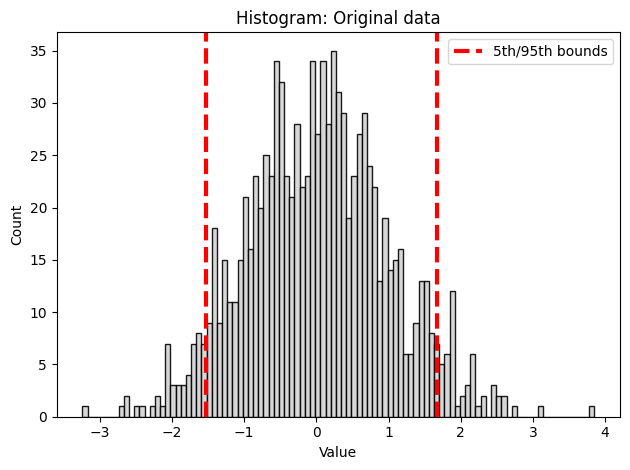

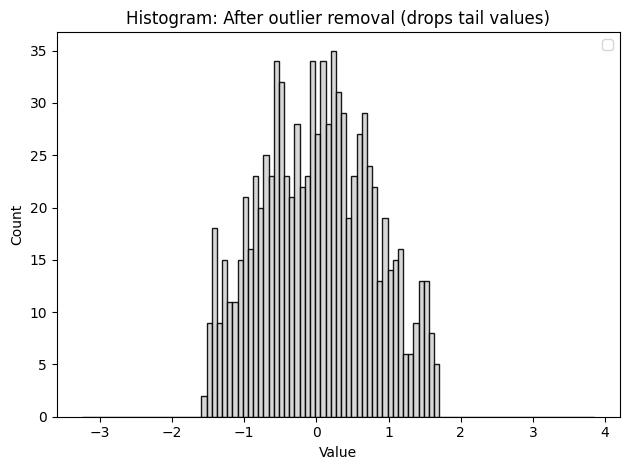

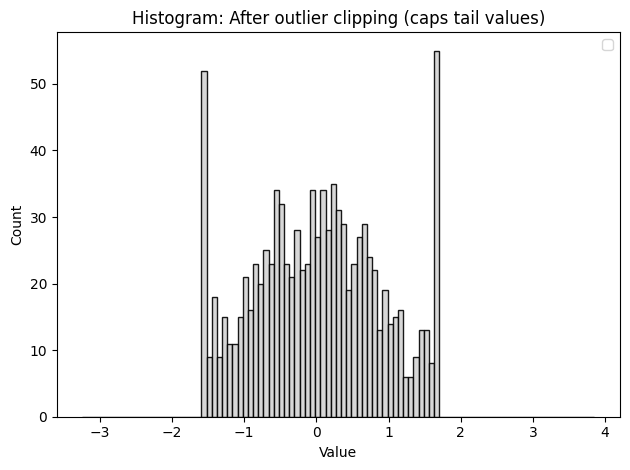

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.random.normal(loc=0.0, scale=1.0, size=1000)

p_low, p_high = 0.05, 0.95
lower = np.quantile(x, p_low)
upper = np.quantile(x, p_high)

# Outlier removal: drop values outside [lower, upper]
x_removed = x[(x >= lower) & (x <= upper)]

# Outlier clipping: cap values to [lower, upper]
x_clipped = np.clip(x, lower, upper)

print(f"Percentile bounds: {p_low:.2f} -> {lower:.3f}, {p_high:.2f} -> {upper:.3f}")
print(f"Original n={len(x)} | Removed n={len(x_removed)} | Clipped n={len(x_clipped)}")

# Use shared binning so shapes are comparable in the following plots
all_min = min(x.min(), x_removed.min(), x_clipped.min())
all_max = max(x.max(), x_removed.max(), x_clipped.max())
bins = np.linspace(all_min, all_max, 100)

def hist_plot(data, title, show_bounds=False):
    plt.figure()
    plt.hist(data, bins=bins, alpha=0.9, color="lightgray", edgecolor="black")
    if show_bounds:
        plt.axvline(lower, linestyle="--", linewidth=3, label="5th/95th bounds", color="red")
        plt.axvline(upper, linestyle="--", linewidth=3, color="red")
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

hist_plot(x, "Histogram: Original data", show_bounds=True)
hist_plot(x_removed, "Histogram: After outlier removal (drops tail values)")
hist_plot(x_clipped, "Histogram: After outlier clipping (caps tail values)")

plt.show()


In [7]:
len(bins)

100

In [8]:
bins[:10]

array([-3.24126734, -3.16961079, -3.09795423, -3.02629768, -2.95464112,
       -2.88298457, -2.81132802, -2.73967146, -2.66801491, -2.59635836])

# Difference: Clipping vs. Winsorizing

Example showing the difference between percentile-based clipping and winsorizing.

Key point:
- Clipping caps values to the percentile thresholds themselves
- Winsorizing replaces extreme values with the nearest *existing* value

In [9]:
import numpy as np
from scipy.stats.mstats import winsorize

x = np.array([-105, -90, 10, 11, 12, 13, 14, 15, 16, 17, 90, 105])

p_low, p_high = 0.10, 0.90
lower = np.quantile(x, p_low)
upper = np.quantile(x, p_high)

# Outlier clipping
x_clipped = np.clip(x, lower, upper)

# Winsorizing
x_winsorized = winsorize(x, limits=(0.10, 0.10))

# Output comparison
print(f"Percentile bounds ({p_low:.2f}, {p_high:.2f}):")
print(f"  lower = {lower:.2f}, upper = {upper:.2f}\n")

print("Original:   ", x)
print("Clipped:    ", x_clipped)
print("Winsorized: ", np.asarray(x_winsorized))

Percentile bounds (0.10, 0.90):
  lower = -80.00, upper = 82.70

Original:    [-105  -90   10   11   12   13   14   15   16   17   90  105]
Clipped:     [-80.  -80.   10.   11.   12.   13.   14.   15.   16.   17.   82.7  82.7]
Winsorized:  [-90 -90  10  11  12  13  14  15  16  17  90  90]


# Importance of outlier handling (removal, clipping) for machine learning

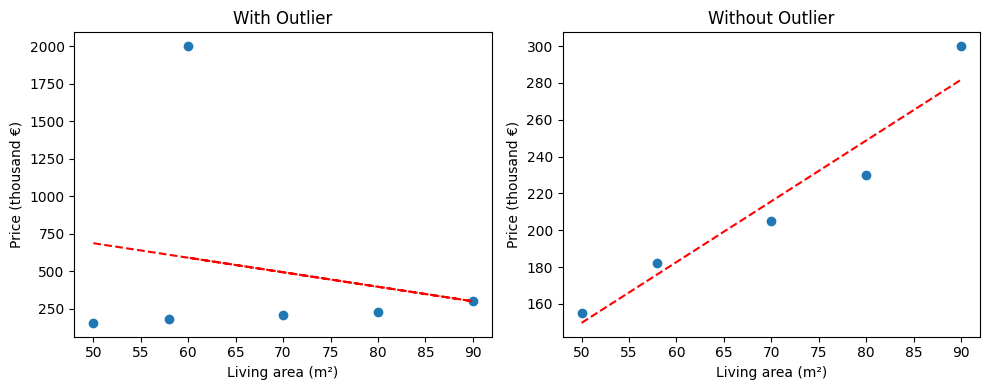

Prediction for 60 m² WITH outlier:    589.4 thousand €
Prediction for 60 m² WITHOUT outlier: 182.7 thousand €
X: [[50]
 [58]
 [70]
 [80]
 [90]
 [60]]
Predictions with outlier: [686.21428571 608.78571429 492.64285714 395.85714286 299.07142857
 589.42857143]
Predictions w/o outlier: [149.67791411 176.09509202 215.7208589  248.74233129 281.76380368
 182.6993865 ]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Living area (m²)
X = np.array([50, 58, 70, 80, 90, 60]).reshape(-1, 1)
# House prices (in thousand €)
y = np.array([155, 182, 205, 230, 300, 2000])  # OUTLIER

# Train model WITH outlier
model_with_outlier = LinearRegression()
model_with_outlier.fit(X, y)
pred_with_outlier = model_with_outlier.predict([[60]])[0]

# Remove outlier (manual)
X_clean = X[:-1]
y_clean = y[:-1]

# Train model WITHOUT outlier
model_without_outlier = LinearRegression()
model_without_outlier.fit(X_clean, y_clean)
pred_without_outlier = model_without_outlier.predict([[60]])[0]

# Plot comparison
plt.figure(figsize=(10, 4))

# With outlier
plt.subplot(1, 2, 1)
plt.scatter(X, y)
plt.plot(X, model_with_outlier.predict(X), color="red", linestyle="--")
plt.title("With Outlier")
plt.xlabel("Living area (m²)")
plt.ylabel("Price (thousand €)")

# Without outlier
plt.subplot(1, 2, 2)
plt.scatter(X_clean, y_clean)
plt.plot(X_clean, model_without_outlier.predict(X_clean), color="red", linestyle="--")
plt.title("Without Outlier")
plt.xlabel("Living area (m²)")
plt.ylabel("Price (thousand €)")

plt.tight_layout()
plt.show()

# Print results
print(f"Prediction for 60 m² WITH outlier:    {pred_with_outlier:.1f} thousand €")
print(f"Prediction for 60 m² WITHOUT outlier: {pred_without_outlier:.1f} thousand €")

print("X:",X)
print("Predictions with outlier:", model_with_outlier.predict(X))
print("Predictions w/o outlier:", model_without_outlier.predict(X))

# z - Scores

z-scores (also called standard scores) tell you how far a value is from the average of a dataset, measured in standard deviations.

A z-score answers the question: “How unusual is this value compared to the rest?”

In [11]:
import numpy as np

# data (300 is an obvious outlier)
x = np.array([10, 12, 11, 217, 13, 12, 11, 10, 9, 12])

# compute z-scores
mean = x.mean()
std = x.std()
z = (x - mean) / std

# flag outliers
threshold = 2
outliers = np.abs(z) > threshold

print("z-scores:", np.round(z, 3))
print("outlier values:", x[outliers])


z-scores: [-0.351 -0.319 -0.335  2.999 -0.303 -0.319 -0.335 -0.351 -0.367 -0.319]
outlier values: [217]


# Modified z-Score

The modified z-score was introduced to make outlier detection robust to skewed distributions and existing outliers, where the classic z-score (based on mean and standard deviation) becomes unreliable.

It replaces the mean with the median and the standard deviation with the median absolute deviation (MAD), and uses a scaling factor (0.6745) so that, for normally distributed data, the scores are comparable to standard z-scores.

classic z-score outliers:   6  -> [ 46.10569748  46.5700489   49.56828608  80.          90.
 120.        ]
modified z-score outliers:  19 -> [ 35.03557475  34.92807133  43.3414634   35.67798138  42.44036983
  36.12309406  46.10569748  37.23557009  46.5700489   43.15458562
  42.6877394   35.02526923  49.56828608  34.83575221  36.64960123
  42.83865576  80.          90.         120.        ]


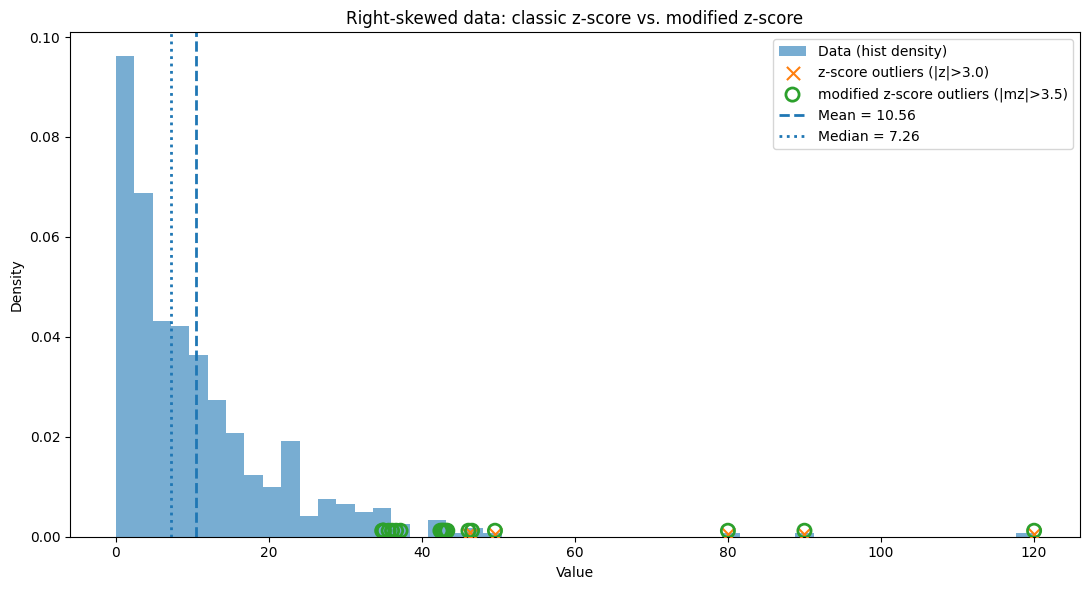

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data: right-skewed + injected outliers
np.random.seed(42)
x = np.r_[np.random.exponential(scale=10, size=500), [80, 90, 120]]

# --- Classic z-score
z = (x - x.mean()) / x.std(ddof=0)

# --- Modified z-score (median/MAD)
med = np.median(x)
mad = np.median(np.abs(x - med))
mz = np.zeros_like(x) if mad == 0 else 0.6745 * (x - med) / mad

# --- Outlier masks
z_out = np.abs(z) > 3.0
mz_out = np.abs(mz) > 3.5

print(f"classic z-score outliers:   {np.where(z_out)[0].size}  -> {x[z_out]}")
print(f"modified z-score outliers:  {np.where(mz_out)[0].size} -> {x[mz_out]}")

# --- Plot
plt.figure(figsize=(11, 6))
plt.hist(x, bins=50, density=True, alpha=0.6, label="Data (hist density)")

# place markers slightly above 0 so they're visible
y_z  = np.full(z_out.sum(),  0.0006)
y_mz = np.full(mz_out.sum(), 0.0012)

plt.scatter(x[z_out],  y_z,  marker="x", s=90, color="tab:orange",
            label="z-score outliers (|z|>3.0)", zorder=5)

plt.scatter(x[mz_out], y_mz, marker="o", s=90, facecolors="none",
            edgecolors="tab:green", linewidths=2,
            label="modified z-score outliers (|mz|>3.5)", zorder=6)

plt.axvline(x.mean(), linestyle="--", linewidth=2, label=f"Mean = {x.mean():.2f}")
plt.axvline(med,      linestyle=":",  linewidth=2, label=f"Median = {med:.2f}")

plt.title("Right-skewed data: classic z-score vs. modified z-score")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


# IQR-based outlier detection and removal

In [13]:
import numpy as np

x = np.array([10, 12, 11, 217, 13, 12, 11, 10, 9, 12])

# IQR method
q1 = np.percentile(x, 25)
q3 = np.percentile(x, 75)
iqr = q3 - q1

low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

# outliers + cleaned data
outliers = (x < low) | (x > high)
x_clean = x[~outliers]

print("bounds:", (low, high))
print("outliers:", x[outliers])
print("cleaned:", x_clean)


bounds: (7.625, 14.625)
outliers: [217]
cleaned: [10 12 11 13 12 11 10  9 12]


# Boxplot

A boxplot is a visual implementation of the IQR-based outlier rule.

What a boxplot shows:
- Box → the interquartile range (IQR = Q3 − Q1)
- Line inside the box → the median
- Whiskers → extend to the most extreme points within [Q1-1.5*IQR, Q3+1.5*IQR]
- Points beyond the whiskers → outliers

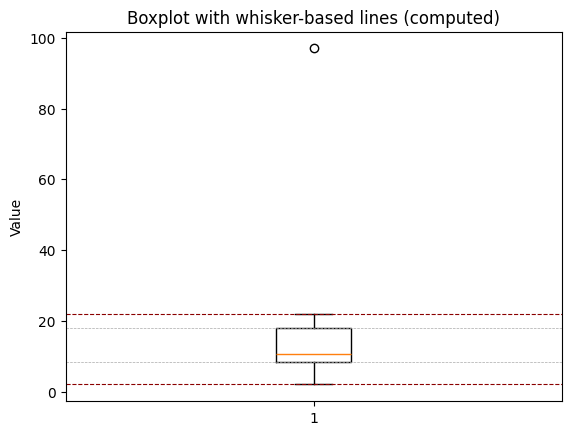

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([20, 2, 8, 97, 3, 22, 11, 10, 9, 12])

q1 = np.quantile(x, 0.25)
q3 = np.quantile(x, 0.75)
iqr = q3 - q1

lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

lower_whisker = np.min(x[x >= lower_fence])
upper_whisker = np.max(x[x <= upper_fence])

plt.boxplot(x)
plt.ylabel("Value")
plt.title("Boxplot with whisker-based lines (computed)")

plt.axhline(q1, color="darkgray", linestyle="--", lw=0.5)
plt.axhline(q3, color="darkgray", linestyle="--", lw=0.5)

plt.axhline(lower_whisker, color="darkred", linestyle="--", lw=0.8)
plt.axhline(upper_whisker, color="darkred", linestyle="--", lw=0.8)

plt.show()

# Multi-variate outlier detection: Isolation Forest

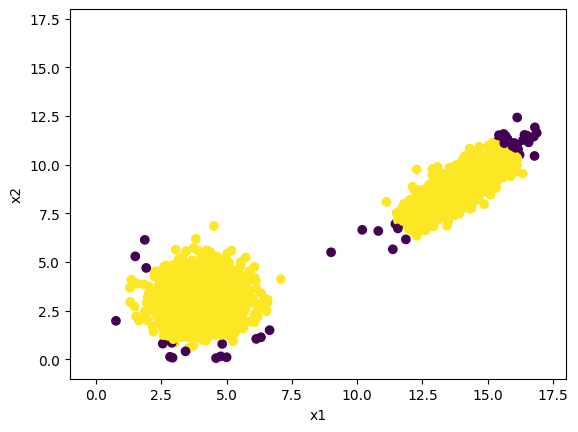

In [15]:
import numpy as np
np.random.seed(42)

N1 = 1000
N2 = 1000

mean1 = [4,3]
cov1 = [[1,0],
        [0,1]
       ]

mean2 = [14,9]
cov2 = [[1,+0.8],
        [+0.8,1]
       ]

p1 = np.random.multivariate_normal(mean1, cov1, size=N1)
p2 = np.random.multivariate_normal(mean2, cov2, size=N2)
p3 = np.array( [[9.0,5.5]] )
p = np.vstack( [p1,p2,p3] )

from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=100, contamination=50/(N1+N2+1)).fit(p)
preds = model.predict(p)


import matplotlib.pyplot as plt
plt.scatter(p[:,0], p[:,1], c=preds)
plt.xlim(-1,18)
plt.ylim(-1,18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Multi-variate outlier detection: DBSCAN

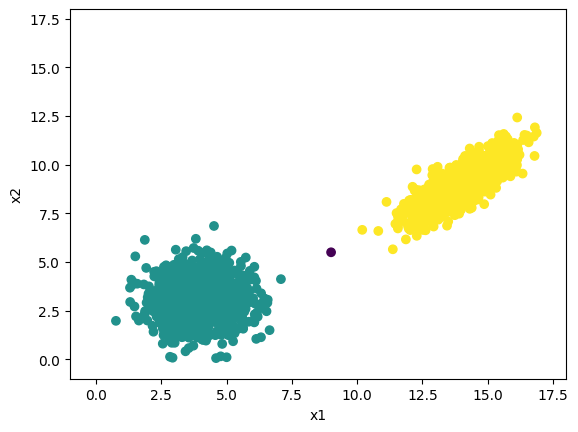

In [16]:
import numpy as np
np.random.seed(42)

N1 = 1000
N2 = 1000

mean1 = [4,3]
cov1 = [[1,0],
        [0,1]
       ]

mean2 = [14,9]
cov2 = [[1,+0.8],
        [+0.8,1]
       ]

p1 = np.random.multivariate_normal(mean1, cov1, size=N1)
p2 = np.random.multivariate_normal(mean2, cov2, size=N2)
p3 = np.array( [[9.0,5.5]] )
p = np.vstack( [p1,p2,p3] )

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1.0, min_samples=3).fit(p)


import matplotlib.pyplot as plt
plt.scatter(p[:,0], p[:,1], c=clustering.labels_)
plt.xlim(-1,18)
plt.ylim(-1,18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Multi-variate outlier detection: Local Outlier Factor (LOF)

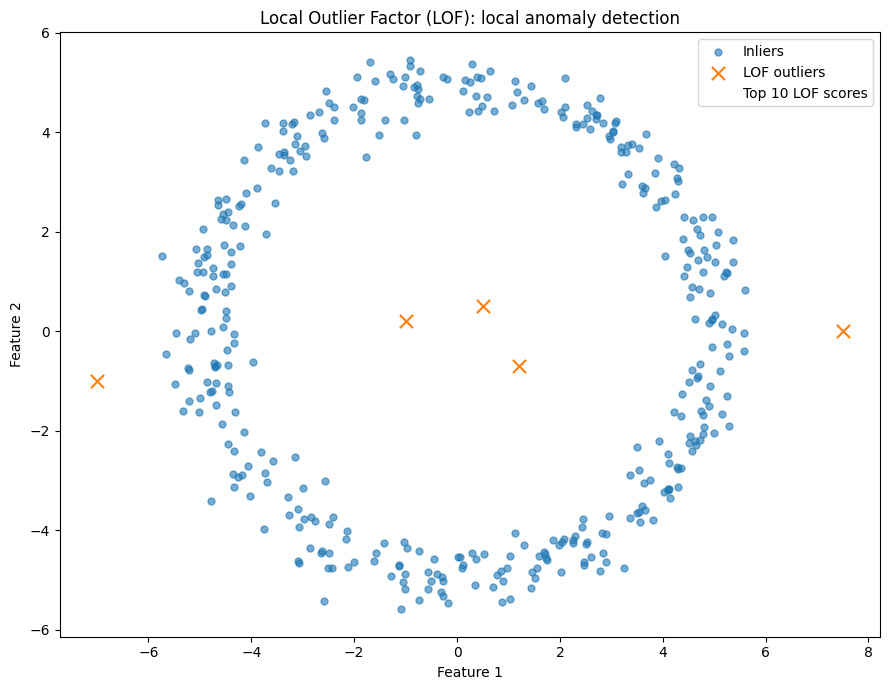

Top points by LOF score:
index=400, point=[0.5 0.5], LOF≈3.33, label=OUTLIER
index=401, point=[-1.   0.2], LOF≈3.17, label=OUTLIER
index=402, point=[ 1.2 -0.7], LOF≈2.99, label=OUTLIER
index=403, point=[7.5 0. ], LOF≈2.24, label=OUTLIER
index=404, point=[-7. -1.], LOF≈1.93, label=OUTLIER
index= 10, point=[-2.58150231 -5.41777906], LOF≈1.18, label=INLIER
index= 44, point=[-5.72890292  1.50578493], LOF≈1.17, label=INLIER
index=258, point=[-4.7935026  -3.40329751], LOF≈1.17, label=INLIER
index= 78, point=[-1.76754456  3.50014206], LOF≈1.11, label=INLIER
index=136, point=[ 3.25000263 -4.75999553], LOF≈1.10, label=INLIER


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Generate example data: a ring-shaped structure
# plus a few local and global outliers

np.random.seed(7)

n = 400
angles = np.random.rand(n) * 2 * np.pi
radius = 5 + np.random.randn(n) * 0.35
X_ring = np.column_stack([
    radius * np.cos(angles),
    radius * np.sin(angles)
])

# Manually add outliers
X_outliers = np.array([
    [0.5, 0.5],     # inside the ring (local anomaly)
    [-1.0, 0.2],    # inside the ring
    [1.2, -0.7],    # inside the ring
    [7.5, 0.0],     # outside the ring
    [-7.0, -1.0],   # outside the ring
])

X = np.vstack([X_ring, X_outliers])

# Scale features (important for distance-based methods)
X_scaled = StandardScaler().fit_transform(X)

# Fit Local Outlier Factor (LOF)
lof = LocalOutlierFactor(
    n_neighbors=25,
    contamination=0.01  # expected fraction of outliers
)

labels = lof.fit_predict(X_scaled)        # 1 = inlier, -1 = outlier
lof_scores = -lof.negative_outlier_factor_  # higher = more anomalous

# Visualization
inliers = labels == 1
outliers = labels == -1

plt.figure(figsize=(9, 7))

plt.scatter(
    X[inliers, 0],
    X[inliers, 1],
    s=25,
    alpha=0.6,
    label="Inliers"
)

plt.scatter(
    X[outliers, 0],
    X[outliers, 1],
    s=90,
    marker="x",
    label="LOF outliers"
)

# Highlight the most extreme points by LOF score
top_k = 10
top_idx = np.argsort(lof_scores)[-top_k:]

plt.scatter(
    X[top_idx, 0],
    X[top_idx, 1],
    s=140,
    facecolors="none",
    linewidths=2,
    label=f"Top {top_k} LOF scores"
)

plt.title("Local Outlier Factor (LOF): local anomaly detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

# Print the most anomalous points
print("Top points by LOF score:")
for i in top_idx[::-1]:
    print(
        f"index={i:3d}, "
        f"point={X[i]}, "
        f"LOF≈{lof_scores[i]:.2f}, "
        f"label={'OUTLIER' if labels[i] == -1 else 'INLIER'}"
    )